<hr/>

# Dependencies

<hr/>

In [0]:
# Calculation Dependencies

import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering

# Plotting Dependencies
from sklearn import datasets
import matplotlib.pyplot as plt

# Preprocessing dependencies
import csv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# # maybe useful in future
# from sklearn.metrics import silhouette_samples, silhouette_score
# from mpl_toolkits.mplot3d import Axes3D
# from sklearn.model_selection import KFold
# import pandas as pd
# from sklearn import datasets

<hr/>

#  Helper Functions



1.   plot_features - 2d plotting any data array with shape (num_examples, num_features)
2.   PCA_iterative - PCA dimensionality reduction based on desired threshold for the explanation of variance
3.   kmeans_clustering - performs kmeans clustering based on desired number of clusters 



<hr/>

In [0]:
# function that plots every feature against each other
def plot_features(data, labels):
  """
  input args:
    data = numpy array where rows are number of examples and columns are number of features

  
  rows are in order by features 1, 2, ...num_features-1 
  plotted against every other features that hasn't already been plotted
  e.g. row 1 is feature 1 versus 2, 1 versus 3, ...,1 versus num_features
  e.g. row 5 is features 5 versus 6, feature 6 versus 7, ..., 5 versus num_features
  """
  num_feature = data.shape[1]
  plt.figure(figsize=(num_feature*4,num_feature*4));
  for i in range(num_feature):
    for j in range(i+1,num_feature):
      plt.subplot(num_feature,num_feature,i*num_feature+j-i+1)
      plt.scatter(data[:,i],data[:,j],c=labels, label = ('feature ', (i+1), 'versus ', (j+1)))
      plt.legend()
  plt.show()


In [0]:
# Preprocessing, note whitening is False by default
# PCA and whitening
def PCA_iterative(data, threshold, whiten_bool = 'False', n = 0):
  """
  standardizes (0 mean 1 std deviation) and does PCA analysis selecting
  the least amount of components to satisfy the desired threshold
  """
  scaler = StandardScaler()
  scaler.fit(data)
  data = scaler.transform(data) 
  pca = PCA(n_components = data.shape[1], whiten=whiten_bool)
  B = pca.fit_transform(data) 
  print('B shape',B.shape)
  L = pca.explained_variance_
  cl=np.cumsum(L); 

  print(cl)
  for i in range(len(cl)):
    if (cl[i]/cl[-1]) > threshold:
      print('selected first ', i+1, ' components with ', cl[i]/cl[-1], ' explained variance')
      B_PCA = B[:,:(i+1)]
      break

  # PCA scree plot
  plt.subplot(111); 
  plt.ylabel('Total Variance');
  plt.xlabel('Principal component')
  plt.plot(np.arange(1,L.shape[0]+1),cl/cl[-1],'o-r'); 
  plt.ylim(0,None);
  return B_PCA


In [0]:
def kmeans_clustering(num_cluster, data, plot_bool = False):
  print('\n\ninitializing kmeans clustering')
  kmeans = KMeans(init='random', n_clusters=num_cluster, n_init=10).fit(data)
  # list of scores from kmeans method (negative sum of distance squared from cluster center)
  cluster_label, inertia = kmeans.labels_, kmeans.inertia_

  # plots 2D slices of the features
  if plot_bool == True:
    print('plots of clusters with pseudolabels')
    plot_features(data, cluster_label)
  print('inertia is ', inertia)

  return cluster_label


In [0]:
def gmm_clustering(num_cluster, data, plot_bool = False):
  print('\n\ninitializing gmm clustering')
  gmm = GaussianMixture(n_components=num_cluster, n_init=10).fit(data)
  cluster_label, score = gmm.predict(data), gmm.score(data)

  # plots 2D slices of the features
  if plot_bool == True:
    print('plots of clusters with pseudolabels')
    plot_features(data, cluster_label)
  print('score is ', score)

  return cluster_label

In [0]:
def spec_clustering(num_cluster, data, mode, nn = 11, plot_bool = False):
  print('\n\ninitializing spectral clustering with ',mode)
  if mode == 'gaussian':
    spectral = SpectralClustering(random_state = 3, n_clusters=num_cluster, affinity = 'rbf').fit(data)
    # list of scores from kmeans method (negative sum of distance squared from cluster center)
    cluster_label = spectral.labels_

  elif mode == 'knn':
    spectral = SpectralClustering(random_state = 3, n_clusters=num_cluster, affinity = 'nearest_neighbors', n_neighbors = nn) 
    # list of scores from kmeans method (negative sum of distance squared from cluster center)
    cluster_label = spectral.fit_predict(data)

  # plots 2D slices of the features
  if plot_bool == True:
    print('plots of clusters with pseudolabels')
    plot_features(data, cluster_label)
  return cluster_label

In [0]:
# main function that performs preprocessing, kmeans clustering, gaussian mixture clustering, and spectral clustering
def experiment_main(data, image_id, num_cluster, threshold, plot_bool = False):
  """
  inputs: 
    data - a 2D numpy array of shape (num_examples, num_features) with dtype 'float'
    image_id - a 1D numpy array of shape (num_examples) with dtype 'str'
    num_custer - number of desired clusters
    threshold - desired explained variance (range 0 - 1)
    plot_bool - whether to output plots of 2D slices of features or not

  Outputs:
    Printed
      PCA scree plot
      inertia and score for kmeans and gmm respectively
      plots of 2D slices of features
    csv files (rows are examples, column 1 is id, column 2 is pseudolabel).
    1 for each clustering method
  """
  data = np.asarray(data)
  # PCA preprocessing
  data = PCA_iterative(data, threshold, n = data.shape[1])

  # clustering functions
  kmeans_labels = kmeans_clustering(num_cluster, data, plot_bool = plot_bool)
  gmm_labels = gmm_clustering(num_cluster, data, plot_bool = plot_bool)
  spec_gaussian_labels = spec_clustering(num_cluster, data, mode = 'gaussian', plot_bool = plot_bool)
  spec_knn_labels = spec_clustering(num_cluster, data, mode = 'knn', nn = 50, plot_bool = plot_bool)

  np.savetxt('kmeans_labels.csv', np.column_stack((image_id,kmeans_labels.astype('str'))), delimiter = ',',  fmt="%s")
  np.savetxt('gmm_labels.csv', np.column_stack((image_id,gmm_labels.astype('str'))),delimiter = ',',  fmt="%s")
  np.savetxt('spec_gaussian_labels.csv', np.column_stack((image_id,spec_gaussian_labels.astype('str'))),delimiter = ',',  fmt="%s")
  np.savetxt('spec_knn_labels.csv', np.column_stack((image_id,spec_knn_labels.astype('str'))),delimiter = ',',  fmt="%s")

B shape (150, 4)
[2.93808505 3.85824995 4.00599178 4.02684564]
selected first  2  components with  0.9581320720000165  explained variance


initializing kmeans clustering
plots of clusters with pseudolabels


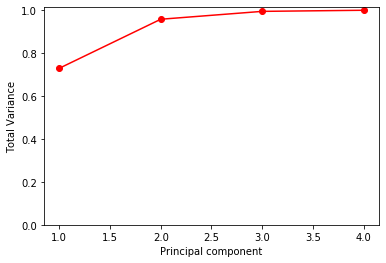

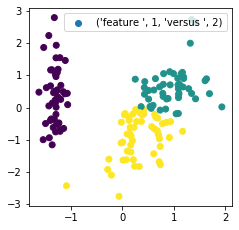

inertia is  93.88495203183275


initializing gmm clustering
plots of clusters with pseudolabels


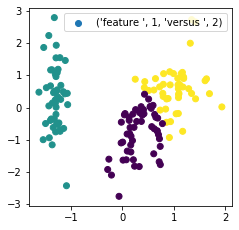

score is  -2.0380653656547163


initializing spectral clustering with  gaussian
plots of clusters with pseudolabels


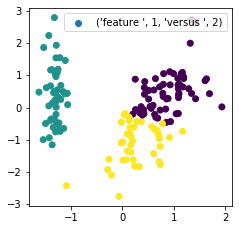



initializing spectral clustering with  knn
plots of clusters with pseudolabels


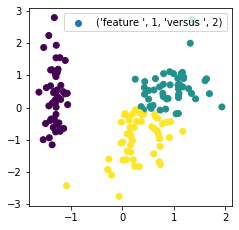

In [114]:
# example of use

iris = datasets.load_iris()
data = iris.data[:,:] 
image_id = np.arange(150)

### hyperparameters
# number of clusters
num_cluster = 3
# desired explained variance during PCA component reduction
threshold = 0.95

experiment_main(data, image_id, num_cluster, threshold, plot_bool = True)